In [2]:
#@markdown #USCMS Diveristy Data: `json` Consolidation
#@markdown Combine various `json` files (`work_*.json`, `people_stats_*.json`,
#@markdown `people_new.json`) together that contain information on individuals:
#@markdown * CMS ID
#@markdown * Gender
#@markdown * Institution
#@markdown * CMS Activity (Role)
#@markdown * Project
#@markdown * Authorship Status  

#@markdown ### Import `python` libraries

import os, json
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import ipywidgets as widgets

from google.colab import drive
drive.mount( '/content/drive' )

%cd /content/drive/My Drive/Colab Notebooks/USCMS-diversity-analysis-main/USCMS-diversity-analysis-main

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/USCMS-diversity-analysis-main/USCMS-diversity-analysis-main


In [3]:
#@markdown ### Select and Load in the Relevant `json` Files
#@markdown Choose the years to consolidate
people_stats = [ option for option in os.listdir( "./Data/" ) if "people_stats" in option ]
work = [ option for option in os.listdir( "./Data/" ) if "work" in option ]
people_stats_years = [ name.split(".")[0].split("_")[2][:4] for name in people_stats ]
work_years = [ name.split(".")[0].split("_")[1][:4] for name in work ]
valid_years = list( set(people_stats_years).intersection(work_years) )
yearlist = widgets.SelectMultiple( options = sorted(valid_years) )
yearlist

SelectMultiple(options=('2015', '2016', '2017', '2018', '2019', '2020'), value=())

In [4]:
#@markdown Load in the `json` files
json_files = {
    "people_new": json.load( open( "Data/people_new.json" ) ),
    "institutes_new": json.load( open( "Data/institutes_new.json" ) ),
    "people_stats": { year: json.load( open( "Data/people_stats_{}1231.json".format( year ) ) ) for year in yearlist.value },
    "work": { year: json.load( open( "Data/work_{}1231.json".format( year ) ) ) for year in yearlist.value }
}

In [5]:
#@markdown Structure a single `dict` to track individuals per year.  The structure
#@markdown of the `dict` will be layers:
#@markdown 1. Year
#@markdown 2. CMS ID
#@markdown 3. Gender, Author, Activity, Institute, Project

#@markdown Begin by structuring the individual `json` files by `YEAR` and `CMSID`,
#@markdown and then the relevant information as listed in bullet point 3.

#@markdown Start with `people_new.json` to associate `CMSID` to `GENDER`.

people_new = {}
people_new_values = { "GENDER": [] }

for person in json_files[ "people_new" ]:
    people_new[ str( person[ "cmsId" ] ) ] = { "GENDER": person[ "gender" ] }
    people_new_values[ "GENDER" ].append( person[ "gender" ] )
    
print( ">> GENDER OPTIONS: {}".format( list( set( people_new_values[ "GENDER" ] ) ) ) )

>> GENDER OPTIONS: ['', 'F', None, 'M']


In [6]:
#@markdown Use `work_*.json` to associate `CMSID` to `PROJECT`
work = { year: {} for year in yearlist.value }
work_values = { year: { "PROJECT": [] } for year in yearlist.value }

for year in yearlist.value:
    work[ year ] = {}
    for institute in json_files[ "work" ][ year ]:
        for person in json_files[ "work" ][ year ][ institute ].keys():
            if person not in list( work[ year ].keys() ):
                work[ year ][ person ] = [ project.upper() for project in list( json_files[ "work" ][ year ][ institute ][ person ].keys() ) ]
            else:
                for project in list( json_files[ "work" ][ year ][ institute ][ person ].keys() ):
                    work[ year ][ person ].append( project.upper() )
            for project in list( json_files[ "work" ][ year ][ institute ][ person ].keys() ):
                work_values[ year ][ "PROJECT" ].append( project.upper() )
        
    print( ">> {} PROJECT OPTIONS: {}".format( year, sorted( list( set( work_values[ year ][ "PROJECT" ] ) ) ) ) )


>> 2015 PROJECT OPTIONS: ['BRIL', 'CT-PPS', 'DAQ', 'ECAL', 'GENERAL', 'HCAL', 'L1 TRIGGER', 'MUON-CSC', 'MUON-DT', 'MUON-RPC', 'OFFLINE AND COMPUTING', 'PPD', 'RUN COORDINATION', 'TRACKER', 'TRIGGER COORDINATION', 'UPGRADE']
>> 2016 PROJECT OPTIONS: ['BRIL', 'CT-PPS', 'DAQ', 'ECAL', 'GENERAL', 'HCAL', 'HGCAL', 'L1 TRIGGER', 'MUON', 'OFFLINE AND COMPUTING', 'PPD', 'RUN COORDINATION', 'TRACKER', 'TRIGGER COORDINATION', 'UPGRADE']
>> 2017 PROJECT OPTIONS: ['BRIL', 'CT-PPS', 'DAQ', 'ECAL', 'GENERAL', 'HCAL', 'L1 TRIGGER', 'MUON', 'OFFLINE AND COMPUTING', 'PPD', 'RUN COORDINATION', 'TRACKER', 'TRIGGER COORDINATION', 'UPGRADE']
>> 2018 PROJECT OPTIONS: ['BRIL', 'DAQ', 'ECAL', 'GENERAL', 'HCAL', 'HGCAL (CE)', 'L1 TRIGGER', 'MUON', 'OFFLINE AND COMPUTING', 'PPD', 'PPS', 'RUN COORDINATION', 'TRACKER', 'TRIGGER COORDINATION', 'UPGRADE']
>> 2019 PROJECT OPTIONS: ['BRIL', 'DAQ', 'ECAL', 'HCAL', 'HGCAL (CE)', 'L1 TRIGGER', 'MTD', 'MUON', 'OFFLINE SOFTWARE AND COMPUTING', 'PPD', 'PPS', 'RUN COORDINA

In [7]:
#@markdown Project options:
project_options = []
for year in yearlist.value:
    for project in list( set( work_values[ year ][ "PROJECT" ] ) ):
        if project not in project_options: project_options.append( project )
print( ">> {}-{} PROJECT OPTIONS:".format( yearlist.value[0], yearlist.value[-1] ) )
for project in sorted( project_options ):
    print( "  - {}".format( project ) )

>> 2015-2020 PROJECT OPTIONS:
  - BRIL
  - CT-PPS
  - DAQ
  - ECAL
  - GENERAL
  - HCAL
  - HGCAL
  - HGCAL (CE)
  - L1 TRIGGER
  - MTD
  - MUON
  - MUON-CSC
  - MUON-DT
  - MUON-RPC
  - OFFLINE AND COMPUTING
  - OFFLINE SOFTWARE AND COMPUTING
  - PPD
  - PPS
  - RUN COORDINATION
  - TRACKER
  - TRIGGER COORDINATION
  - UPGRADE


In [8]:
#@markdown Use `people_stats_*.json` to associate `CMSID` and `ACTIVITY`, `INSTITUTE`, `AUTHOR`.
people_stats = { year: {} for year in yearlist.value }
people_stats_values = { year: {
    "ACTIVITY":  [],
    "INSTITUTE": [],
    "AUTHOR": []
} for year in yearlist.value }

for year in yearlist.value:
    people_stats[ year ] = {}
    for person in json_files[ "people_stats" ][ year ]:
        people_stats[ year ][ str( person[ "cms_id" ] ) ] = {
            "ACTIVITY":  person[ "activity_cms" ] if person[ "activity_cms" ] is not None else "Other",
            "INSTITUTE": person[ "inst_code" ],
            "AUTHOR":    person[ "is_author" ]
        }
        if person[ "activity_cms" ] is None: people_stats_values[ year ][ "ACTIVITY" ].append( "Other" )
        else: people_stats_values[ year ][ "ACTIVITY" ].append( person[ "activity_cms" ] )
        people_stats_values[ year ][ "INSTITUTE" ].append( person[ "inst_code" ] )
        people_stats_values[ year ][ "AUTHOR" ].append( person[ "is_author" ] )

    print( ">> {} ACTIVITY OPTIONS: {}".format( year, sorted( set( people_stats_values[ year ][ "ACTIVITY" ] ) ) ) )

>> 2015 ACTIVITY OPTIONS: ['Administrative', 'Doctoral Student', 'Engineer', 'Engineer Electronics', 'Engineer Mechanical', 'Engineer Software', 'Non-Doctoral Student', 'Other', 'Physicist', 'Technician', 'Theoretical Physicist']
>> 2016 ACTIVITY OPTIONS: ['Administrative', 'Doctoral Student', 'Engineer', 'Engineer Electronics', 'Engineer Mechanical', 'Engineer Software', 'Non-Doctoral Student', 'Other', 'Physicist', 'Technician', 'Theoretical Physicist']
>> 2017 ACTIVITY OPTIONS: ['Administrative', 'Doctoral Student', 'Engineer', 'Engineer Electronics', 'Engineer Mechanical', 'Engineer Software', 'Non-Doctoral Student', 'Other', 'Physicist', 'Technician', 'Theoretical Physicist']
>> 2018 ACTIVITY OPTIONS: ['Administrative', 'Doctoral Student', 'Engineer', 'Engineer Electronics', 'Engineer Mechanical', 'Engineer Software', 'Non-Doctoral Student', 'Other', 'Physicist', 'Technician', 'Theoretical Physicist']
>> 2019 ACTIVITY OPTIONS: ['Administrative', 'Doctoral Student', 'Engineer', 'En

In [9]:
#@markdown Activity options:
activity_options = []
for year in yearlist.value:
    for activity in list( set( people_stats_values[ year ][ "ACTIVITY" ] ) ):
        if activity not in activity_options: activity_options.append( activity )
print( ">> {}-{} ACTIVITY OPTIONS:".format( yearlist.value[0], yearlist.value[-1] ) )
for activity in sorted( activity_options ):
    print( "  - {}".format( activity ) )

>> 2015-2020 ACTIVITY OPTIONS:
  - Administrative
  - Doctoral Student
  - Engineer
  - Engineer Electronics
  - Engineer Mechanical
  - Engineer Software
  - Non-Doctoral Student
  - Other
  - Physicist
  - Technician
  - Theoretical Physicist


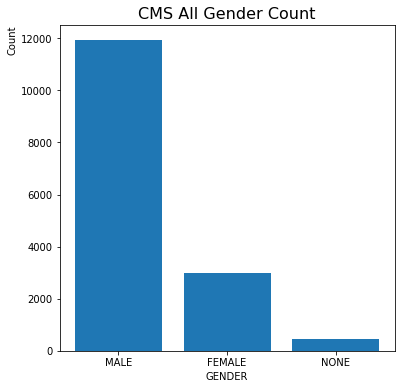

In [10]:
#@markdown ### `json` File Statistics
#@markdown List the possible options for each of the categories and provide some
#@markdown basic plots on the distribution of the options.

#@markdown ### Plot genders of all existing and past CMS members

gender_keys = [ "MALE", "FEMALE", "NONE" ]
gender_plot = { key: 0 for key in gender_keys }
for gender in people_new_values[ "GENDER" ]:
    if gender is None or gender == "":
        gender_plot[ "NONE" ] += 1
    elif gender.upper() == "F":
        gender_plot[ "FEMALE" ] += 1
    elif gender.upper() == "M":
        gender_plot[ "MALE" ] += 1

plt.figure( figsize = (6,6) )
plt.bar( list( gender_plot.keys() ), list( gender_plot.values() ) )
plt.title( "CMS All Gender Count", fontsize = 16 )
plt.ylabel( "Count", y = 1.0, ha = "right" )
plt.xlabel( "GENDER" )
plt.show()

In [11]:
#@markdown Plot the number of members within each project groupde by year.  First,
#@markdown choose a project to view.

project_choice = widgets.Dropdown( options = project_options )
project_choice

Dropdown(options=('UPGRADE', 'GENERAL', 'ECAL', 'TRIGGER COORDINATION', 'L1 TRIGGER', 'MUON-RPC', 'PPD', 'HCAL…

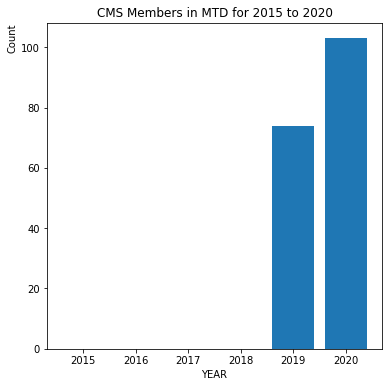

In [12]:
#@markdown ### Plot the member count in each project per year
project_plot = { year: 0 for year in yearlist.value }
for year in yearlist.value:
    for project in work_values[ year ][ "PROJECT" ]:
        if project == project_choice.value:
            project_plot[ year ] += 1
        
plt.figure( figsize = (6,6) )

plt.bar( list( project_plot.keys() ), list( project_plot.values() ) )
plt.title( "CMS Members in {} for {} to {}".format( project_choice.value, yearlist.value[0], yearlist.value[-1] ) )
plt.ylabel( "Count", y = 1.0, ha = "right" )
plt.xlabel( "YEAR" )
plt.show()

In [13]:
#@markdown Plot the number of members based on `ACTIVITY` grouped by year. 
#@markdown First, choose an activity to view
activity_choice = widgets.Dropdown( options = activity_options )
activity_choice

Dropdown(options=('Doctoral Student', 'Administrative', 'Engineer Software', 'Engineer', 'Non-Doctoral Student…

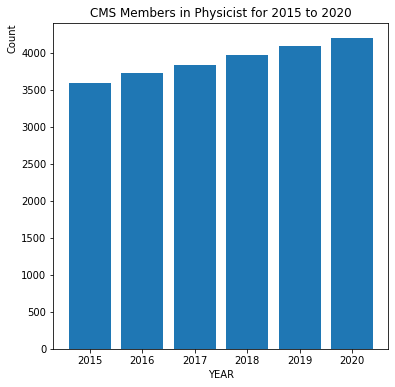

In [14]:
#@markdown ### Plot the CMS member activity per year
activity_plot = { year: 0 for year in yearlist.value }
for year in yearlist.value:
    for activity in people_stats_values[ year ][ "ACTIVITY" ]:
        if activity == activity_choice.value:
            activity_plot[ year ] += 1
        
plt.figure( figsize = (6,6) )

plt.bar( list( activity_plot.keys() ), list( activity_plot.values() ) )
plt.title( "CMS Members in {} for {} to {}".format( activity_choice.value, yearlist.value[0], yearlist.value[-1] ) )
plt.ylabel( "Count", y = 1.0, ha = "right" )
plt.xlabel( "YEAR" )
plt.show()

In [15]:
#@markdown ### Format and Prorudce New `json` File
#@markdown Compile the new `dict`
combined_json = { year: {} for year in yearlist.value }

for year in yearlist.value:
    for ID in sorted( list( set( people_stats[ year ].keys() ).intersection( set( work[ year ].keys() ) ) ) ):
        combined_json[ year ][ str(ID) ] = {}
        combined_json[ year ][ str(ID) ][ "GENDER" ] = people_new[ str(ID) ][ "GENDER" ]
        if str(ID) in work[ year ].keys():
            combined_json[ year ][ str(ID) ][ "PROJECT" ] = work[ year ][ str(ID) ]
        else:
            combined_json[ year ][ str(ID) ][ "PROJECT" ] = [ "OTHER" ]
        if str(ID) in people_stats[ year ].keys():
            combined_json[ year ][ str(ID) ][ "ACTIVITY" ]  = people_stats[ year ][ str(ID) ][ "ACTIVITY" ]
            combined_json[ year ][ str(ID) ][ "INSTITUTE" ] = people_stats[ year ][ str(ID) ][ "INSTITUTE" ]
            combined_json[ year ][ str(ID) ][ "AUTHOR" ]    = people_stats[ year ][ str(ID) ][ "AUTHOR" ]
        else:
            combined_json[ year ][ str(ID) ][ "ACTIVITY" ]  = "OTHER"
            combined_json[ year ][ str(ID) ][ "INSTITUTE" ] = "OTHER"
            combined_json[ year ][ str(ID) ][ "AUTHOR" ]    = None

In [16]:
#@markdown Dump the `json` file
with open( "Data/json_analysis.json", "w" ) as outfile:
    json.dump( combined_json, outfile, indent = 2 )